# Algoritmos de optimización - Reto 3

Nombre: Ana Paula Aravena Cifuentes<br>
Github: https://github.com/rainamelui/03MIAR---Algoritmos-de-Optimizacion--2024 <br>

Mejorar la implementación de colonia de hormigas implementada en clase sobre el TSP mediante una elección de nodo que tenga en consideración una función de probabilidad que depende de las feromonas.

In [1]:
#Modulo de llamadas http para descargar ficheros
!pip install requests

#Libreria del problema TSP: http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsplib.html
!pip install tsplib95

In [2]:
import tsplib95
import random
from math import e
import urllib.request
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gzip


In [3]:
#DATOS DEL PROBLEMA
file = "swiss42.tsp"
url = "http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/swiss42.tsp.gz"
urllib.request.urlretrieve(url, file + '.gz')

with gzip.open(file + '.gz', 'rb') as f_in:
    with open(file, 'wb') as f_out:
        f_out.write(f_in.read())

problem = tsplib95.load(file)

#Nodos
Nodos = list(problem.get_nodes())

#Devuelve la distancia entre dos nodos
def distancia(a,b, problem):
  return problem.get_weight(a,b)

#Devuelve la distancia total de una trayectoria/solucion(lista de nodos)
def distancia_total(solucion, problem):
  distancia_total = 0
  for i in range(len(solucion)-1):
    distancia_total += distancia(solucion[i] ,solucion[i+1] ,  problem)
  return distancia_total + distancia(solucion[len(solucion)-1] ,solucion[0], problem)

## Algoritmo de colonia de hormigas

La función Add_Nodo selecciona al azar un nodo con probabilidad uniforme.
Para ser mas eficiente debería seleccionar el próximo nodo siguiendo la probabilidad correspondiente a la ecuación:

$p^k_{ij}(t) = \frac{[\tau_{ij}(t)]^\alpha[\nu_{ij}]^\beta}{\sum_{l\in J^k_i} [\tau_{il}(t)]^\alpha[\nu_{il}]^\beta}$, si $j \in J^k_i$

$p^k_{ij}(t) = 0$, si $j \notin J^k_i$

In [4]:
import random

def Add_Nodo(problem, H, T, alpha=1, beta=2):
    Nodos = list(problem.get_nodes())
    prob = []
    actual = H[-1]
    denominator_sum = 0
    for nodo in Nodos:
        if nodo not in H:
            tau = T[actual][nodo] ** alpha
            visibility = (1 / distancia(actual, nodo, problem)) ** beta
            denominator_sum += tau * visibility
    for nodo in Nodos:
        if nodo not in H:
            tau = T[actual][nodo] ** alpha
            visibility = (1 / distancia(actual, nodo, problem)) ** beta
            probability = (tau * visibility) / denominator_sum if denominator_sum != 0 else 0
            prob.append((nodo, probability))
    selected_node = random.choices(prob, weights=[p[1] for p in prob])[0][0]
    return selected_node


In [5]:
def Add_Nodo_antiguo(problem, H ,T ) :
  #Mejora:Establecer una funcion de probabilidad para
  # añadir un nuevo nodo dependiendo de los nodos mas cercanos y de las feromonas depositadas
  Nodos = list(problem.get_nodes())
  return random.choice(   list(set(range(1,len(Nodos))) - set(H) )  )

In [6]:
def Incrementa_Feromona(problem, T, H ) :
  #Incrementa segun la calidad de la solución. Añadir una cantidad inversamente proporcional a la distancia total
  for i in range(len(H)-1):
    T[H[i]][H[i+1]] += 1000/distancia_total(H, problem)
  return T

def Evaporar_Feromonas(T ):
  #Evapora 0.3 el valor de la feromona, sin que baje de 1
  #Mejora:Podemos elegir diferentes funciones de evaporación dependiendo de la cantidad actual y de la suma total de feromonas depositadas,...
  T = [[ max(T[i][j] - 0.3 , 1) for i in range(len(Nodos)) ] for j in range(len(Nodos))]
  return T

In [7]:
def hormigas(problem, N,modo) :
  inicio_total = time.time()
  #problem = datos del problema
  #N = Número de agentes(hormigas)

  #Nodos
  Nodos = list(problem.get_nodes())
  #Aristas
  Aristas = list(problem.get_edges())

  #Inicializa las aristas con una cantidad inicial de feromonas:1
  #Mejora: inicializar con valores diferentes dependiendo diferentes criterios
  T = [[ 1 for _ in range(len(Nodos)) ] for _ in range(len(Nodos))]


  #Se generan los agentes(hormigas) que serán estructuras de caminos desde 0
  Hormiga = [[0] for _ in range(N)]

  #Recorre cada agente construyendo la solución
  for h in range(N) :
    #Para cada agente se construye un camino
    for i in range(len(Nodos)-1) :

      #Elige el siguiente nodo
      if modo==1:
        Nuevo_Nodo = Add_Nodo(problem, Hormiga[h] ,T )
        Hormiga[h].append(Nuevo_Nodo)
      elif modo==2:
        Nuevo_Nodo = Add_Nodo_antiguo(problem, Hormiga[h] ,T )
        Hormiga[h].append(Nuevo_Nodo)


    #Incrementa feromonas en esa arista
    T = Incrementa_Feromona(problem, T, Hormiga[h] )
    #print("Feromonas(1)", T)

    #Evapora Feromonas
    T = Evaporar_Feromonas(T)
    #print("Feromonas(2)", T)

    #Seleccionamos el mejor agente
  mejor_solucion = []
  mejor_distancia = 10e100
  for h in range(N) :
    distancia_actual = distancia_total(Hormiga[h], problem)
    if distancia_actual < mejor_distancia:
      mejor_solucion = Hormiga[h]
      mejor_distancia =distancia_actual
  fin_total = time.time()
  tiempo_total = fin_total - inicio_total  # Calcula el tiempo total de ejecución

  print("Tiempo total de ejecución:", tiempo_total, "segundos")

  print(mejor_solucion)
  print(mejor_distancia)
  return(mejor_distancia,tiempo_total)

In [8]:
dist1,tiempo1=hormigas(problem, 1000, modo=1)

Tiempo total de ejecución: 14.413258790969849 segundos
[0, 27, 2, 28, 3, 1, 38, 34, 20, 33, 31, 36, 35, 17, 7, 32, 4, 26, 5, 25, 11, 12, 13, 19, 37, 15, 16, 14, 18, 29, 23, 41, 9, 22, 39, 21, 40, 24, 30, 8, 10, 6]
2040


In [9]:
dist2,tiempo2=hormigas(problem, 1000, modo=2)

Tiempo total de ejecución: 7.91011905670166 segundos
[0, 36, 1, 4, 26, 10, 28, 19, 37, 17, 6, 30, 18, 14, 27, 2, 7, 25, 40, 21, 39, 3, 24, 5, 8, 41, 31, 15, 13, 11, 20, 35, 16, 38, 33, 32, 29, 9, 22, 23, 12, 34]
3949


In [10]:
dist3,tiempo3=hormigas(problem, 2000, modo=1)

Tiempo total de ejecución: 29.191509008407593 segundos
[0, 3, 2, 27, 30, 32, 28, 6, 1, 7, 31, 17, 37, 15, 16, 14, 19, 13, 5, 26, 18, 12, 11, 25, 8, 9, 21, 39, 20, 33, 34, 29, 4, 10, 41, 23, 40, 24, 38, 22, 35, 36]
1900


In [11]:
dist4,tiempo4=hormigas(problem, 2000, modo=2)

Tiempo total de ejecución: 12.151171684265137 segundos
[0, 22, 9, 38, 24, 33, 35, 31, 2, 23, 40, 4, 13, 37, 39, 8, 41, 19, 11, 26, 36, 5, 16, 28, 21, 27, 1, 3, 34, 32, 7, 20, 29, 30, 17, 12, 18, 25, 10, 6, 14, 15]
3844


In [12]:
dist5,tiempo5=hormigas(problem, 500, modo=1)

Tiempo total de ejecución: 7.892927646636963 segundos
[0, 27, 2, 3, 4, 12, 11, 25, 8, 10, 29, 39, 21, 34, 20, 33, 18, 26, 6, 14, 16, 7, 1, 19, 13, 5, 15, 37, 36, 35, 31, 17, 32, 28, 30, 22, 38, 24, 40, 41, 23, 9]
2047


In [13]:
dist6,tiempo6=hormigas(problem, 500, modo=2)

Tiempo total de ejecución: 3.220031499862671 segundos
[0, 30, 22, 36, 35, 34, 2, 8, 13, 21, 37, 17, 18, 7, 5, 6, 39, 29, 38, 27, 33, 19, 14, 15, 32, 3, 9, 24, 41, 12, 1, 16, 4, 28, 40, 23, 20, 31, 25, 10, 26, 11]
3978


In [14]:
dist7,tiempo7=hormigas(problem, 1200, modo=1)

Tiempo total de ejecución: 16.252805709838867 segundos
[0, 1, 26, 5, 25, 12, 11, 18, 13, 19, 14, 16, 15, 17, 37, 8, 41, 10, 29, 28, 30, 27, 2, 3, 4, 6, 7, 31, 36, 35, 20, 34, 38, 21, 39, 22, 9, 23, 40, 24, 32, 33]
2030


In [15]:
dist8,tiempo8=hormigas(problem, 1200, modo=2)

Tiempo total de ejecución: 8.001408338546753 segundos
[0, 30, 35, 1, 12, 5, 18, 11, 32, 13, 7, 6, 26, 39, 10, 29, 20, 34, 19, 4, 21, 9, 40, 23, 25, 41, 22, 27, 15, 33, 3, 24, 38, 2, 36, 16, 17, 37, 31, 28, 8, 14]
3882


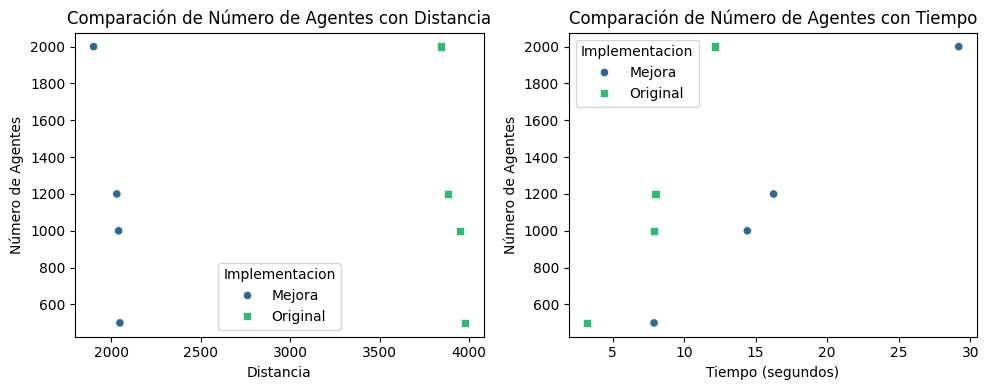

In [16]:
distancias = [dist1, dist2, dist3, dist4, dist5, dist6, dist7, dist8]
tiempos = [tiempo1, tiempo2, tiempo3, tiempo4, tiempo5, tiempo6, tiempo7, tiempo8]
num_agentes = [1000, 1000, 2000, 2000, 500, 500,1200,1200]
implementacion = ["Mejora", "Original", "Mejora", "Original","Mejora", "Original","Mejora", "Original"]

df = pd.DataFrame({'Tiempo': tiempos, 'Distancia': distancias, 'Número de Agentes': num_agentes, 'Implementacion': implementacion})

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df, y='Número de Agentes', x='Distancia', hue='Implementacion', palette='viridis', style='Implementacion', markers=['o', 's'])
plt.ylabel('Número de Agentes')
plt.xlabel('Distancia')
plt.title('Comparación de Número de Agentes con Distancia')
plt.legend(title='Implementacion')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, y='Número de Agentes', x='Tiempo', hue='Implementacion', palette='viridis', style='Implementacion', markers=['o', 's'])
plt.ylabel('Número de Agentes')
plt.xlabel('Tiempo (segundos)')
plt.title('Comparación de Número de Agentes con Tiempo')
plt.legend(title='Implementacion')

plt.tight_layout()
plt.show()
